### Necessary Library

In [1]:
# Preprocessing Module
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
pd.set_option('display.max_columns', 50)

# Visualization Module
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Dimensionality Reduction Module
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Model Training Module
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

#Miscellaneous
import os, sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Data Preprocessing by handling missing value

In [34]:
df=pd.read_csv('/Users/armanruzgar/Documents/Dev/cs4950/healthcare-dataset-stroke-data.csv') # Read the dataset from the data path
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [35]:
columns = ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke'] # Rename the column due to formatting issue
df.columns = columns
del df['id']

categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] #  Categorical features column
numerical_features = ['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'] # Numerical_features column
target = 'stroke' # Target column
assert(len(categorical_features)+len(numerical_features) == df.shape[1]-2) # check for mismatch of number of columns

In [36]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [37]:
for col in categorical_features:
  print(df[col].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [38]:
# Fill the missing numerical value with it's median value
for col in numerical_features:
  df[col] = df[col].fillna(df[col].median())

df[numerical_features].isna().sum()

hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
dtype: int64

In [39]:
# Fill the missing categorical value with it's most frequent value
for col in categorical_features:
  df[col] = df[col].fillna(df[col].value_counts().index[0])

df[categorical_features].isna().sum()

gender            0
ever_married      0
work_type         0
Residence_type    0
smoking_status    0
dtype: int64

In [40]:
df[numerical_features] = df[numerical_features].astype(float) # Convert the datatype of the numerical column into float types
df.shape

(5110, 11)

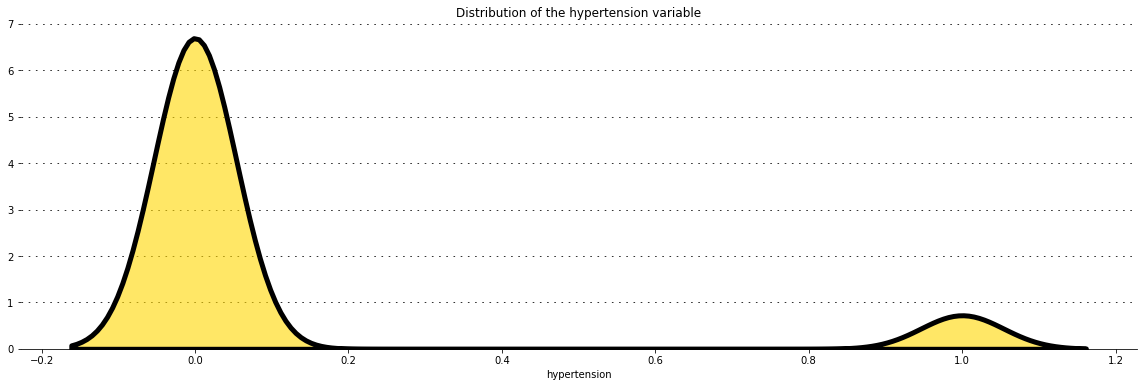

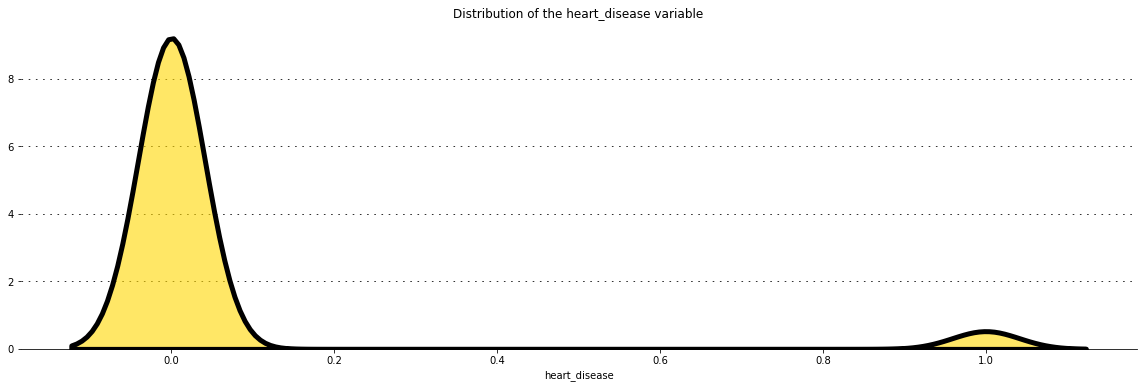

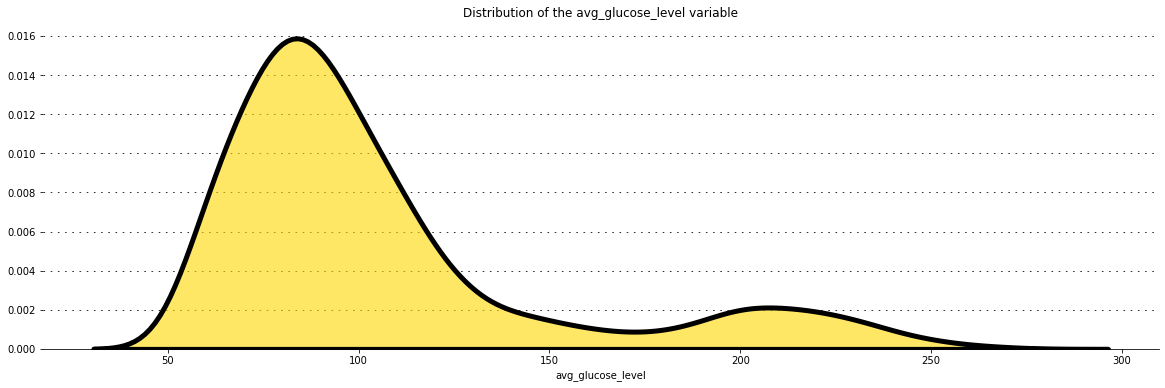

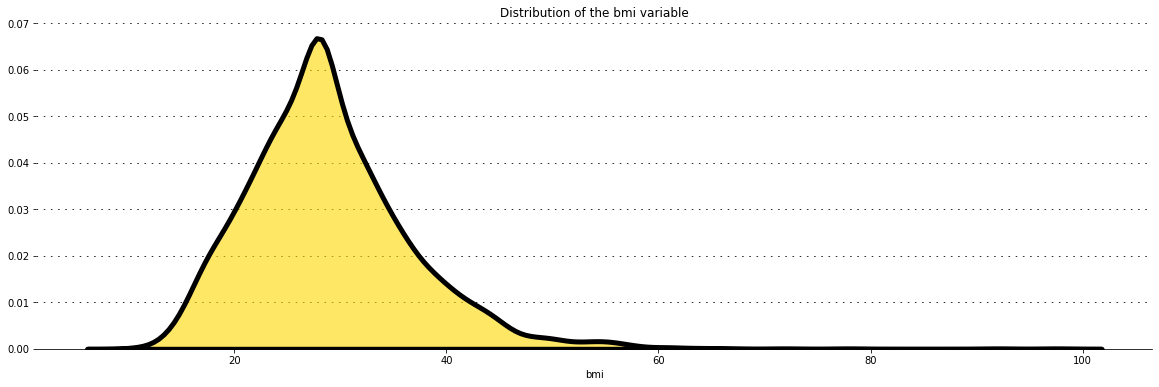

In [41]:
# Visualization of numerical features
i = 0
for col in numerical_features:
  fig=plt.figure(figsize=(20, 6),facecolor='white')
  grid = fig.add_gridspec(1,1)
  ax = fig.add_subplot(grid[0,0])  
  sns.kdeplot(x=df[col],ax=ax,shade=True, color='gold', alpha=0.6,zorder=3,linewidth=5,edgecolor='black').set(title = f'Distribution of the {col} variable')
  ax.set_ylabel('')
  ax.grid(which='both', axis='y', zorder=0, color='black', linestyle=':', dashes=(2,7))
  
  for dir in ['top','right','left']:
      ax.spines[dir].set_visible(False)
        
  i += 1


In [42]:
# Visualization of categorical features
fig = make_subplots(
    rows=3, cols=2, subplot_titles=('gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'),
    specs=[[{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}]],
)

colours = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']

c = 0
for col in categorical_features:
  fig.add_trace(go.Pie(labels=np.array(df[col].value_counts().index),
                     values=[x for x in df[col].value_counts()],
                     textinfo='label+percent', rotation=-45, hole=.35,
                     marker_colors=colours),
                     row=c//2+1, col=c%2+1)
  c += 1
  
fig.update_layout(height=2500, font=dict(size=14), showlegend=False)
fig.show()

In [43]:
#Relationship among the features
corr=df.corr()
corr

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276398,0.263796,0.238171,0.324296,0.245257
hypertension,0.276398,1.000000,0.108306,0.174474,0.158293,0.127904
heart_disease,0.263796,0.108306,1.000000,0.161857,0.036916,0.134914
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,0.166876,0.131945
bmi,0.324296,0.158293,0.036916,0.166876,1.000000,0.036110
stroke,0.245257,0.127904,0.134914,0.131945,0.036110,1.000000


In [44]:
# Encode the categrocial features
for col in categorical_features:
  df[col] = LabelEncoder().fit_transform(df[col])

In [45]:
# Mapping the output label as 1 and 0
mapping = dict(zip(df[target].unique(), [1,0]))
df[target] = df[target].map(mapping)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0.0,1.0,1,2,1,228.69,36.6,1,1
1,0,61.0,0.0,0.0,1,3,0,202.21,28.1,2,1
2,1,80.0,0.0,1.0,1,2,0,105.92,32.5,2,1
3,0,49.0,0.0,0.0,1,2,1,171.23,34.4,3,1
4,0,79.0,1.0,0.0,1,3,0,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1.0,0.0,1,2,1,83.75,28.1,2,0
5106,0,81.0,0.0,0.0,1,3,1,125.20,40.0,2,0
5107,0,35.0,0.0,0.0,1,3,0,82.99,30.6,2,0
5108,1,51.0,0.0,0.0,1,2,0,166.29,25.6,1,0


In [46]:
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [47]:
# Prepare as input-output format for training
X = df.drop(target, axis = 1)
y = df[target]
X.shape, y.shape

((5110, 10), (5110,))

In [48]:
# Normalize the data
X = StandardScaler().fit_transform(X)
# MiMaxScaling (-1 to 1) range
X = MinMaxScaler().fit_transform(X)

In [49]:
# Stratified Random split with test size 20%
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2)
split.get_n_splits(X, y)
train_idx, test_idx = next(split.split(X, y))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
X_train.shape, X_test.shape

((4088, 10), (1022, 10))

In [50]:
# Save the dataframe
df.to_pickle('/Users/armanruzgar/Documents/Dev/cs4950/df stroke.pkl', compression  = 'gzip')

# Train the model

In [ ]:
# df = pd.read_pickle('/Users/armanruzgar/Documents/Dev/cs4950/df stroke.pkl', compression  = 'gzip')
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,stratify=y)

## KNN

In [51]:
clf = KNeighborsClassifier()
grid = {'n_neighbors':[1, 2, 3, 4, 5, 7, 9, 10],
        'leaf_size':[1, 2, 3, 5,10]}
model = GridSearchCV(estimator = clf, param_grid = grid, cv = 5, verbose = 3, n_jobs = -1)
model.fit(X_train, y_train)
model.best_params_, model.score(X_train, y_train), model.score(X_test, y_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


({'leaf_size': 1, 'n_neighbors': 10}, 0.9515655577299413, 0.9510763209393346)

##SVC

In [52]:
clf = SVC()
grid = {'C':[0.1, 0.5, 1, 5, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']}
model = GridSearchCV(estimator = clf, param_grid = grid, cv = 5, verbose = 3, n_jobs = -1)
model.fit(X_train, y_train)
model.best_params_, model.score(X_train, y_train), model.score(X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


({'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'},
 0.951320939334638,
 0.9510763209393346)

## RFC

In [53]:
clf = model = RandomForestClassifier()
grid = {'max_depth': [2, 3, 5, 10,],
        'max_features':[2, 3, 5],
        'ccp_alpha': [0, 0.1]}
model = GridSearchCV(estimator = clf, param_grid = grid, cv = 5, verbose = 2, n_jobs = -1)
model.fit(X_train, y_train)
model.best_params_, model.score(X_train, y_train), model.score(X_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


({'ccp_alpha': 0, 'max_depth': 2, 'max_features': 2},
 0.951320939334638,
 0.9510763209393346)

Text(0.5, 0, 'Feature Importance')

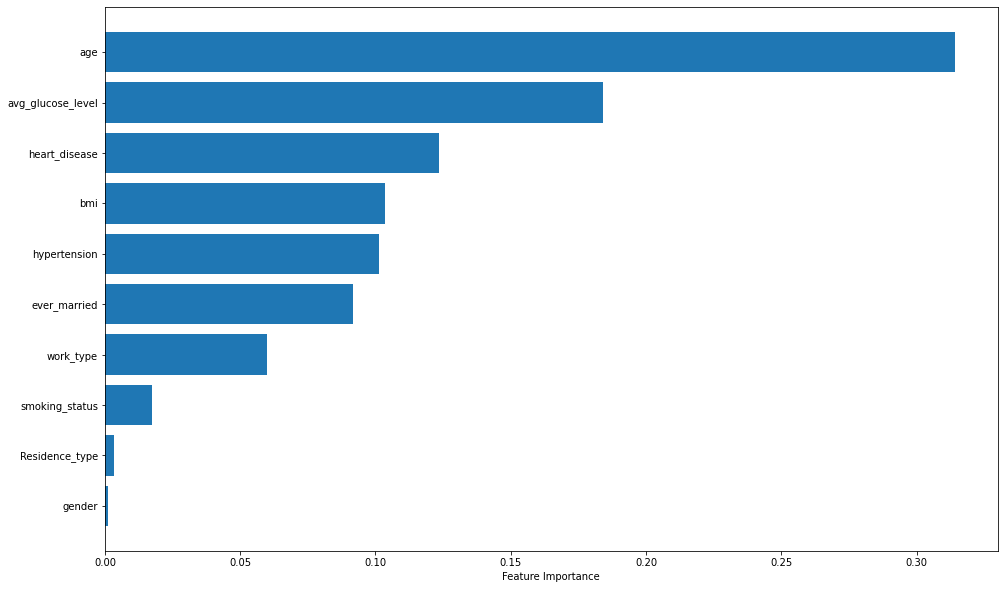

In [27]:
sort = model.best_estimator_.feature_importances_.argsort()
plt.rcParams["figure.figsize"] = (16, 10)
plt.barh( df.columns[sort], model.best_estimator_.feature_importances_[sort])
plt.xlabel("Feature Importance")

## GAussianProcessClassifier

In [29]:
clf = GaussianProcessClassifier()
grid = {'kernel': [1.0 * RBF(1)]}
model = GridSearchCV(estimator = clf, param_grid = grid, cv = 5, verbose = 2, n_jobs = -1)
model.fit(X_train, y_train)
model.best_params_, model.score(X_train, y_train), model.score(X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: ignored

## DecisionTreeClassifier

In [30]:
clf =  DecisionTreeClassifier()
grid = {'max_depth': [2, 3, 5, 10, 15, 20],
        'max_features':['auto', 'sqrt', 'log2']}
model = GridSearchCV(estimator = clf, param_grid = grid, cv = 5, verbose = 2, n_jobs = -1)
model.fit(X_train, y_train)
model.best_params_, model.score(X_train, y_train), model.score(X_test, y_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


({'max_depth': 2, 'max_features': 'auto'},
 0.951320939334638,
 0.9510763209393346)

Text(0.5, 0, 'Feature Importance')

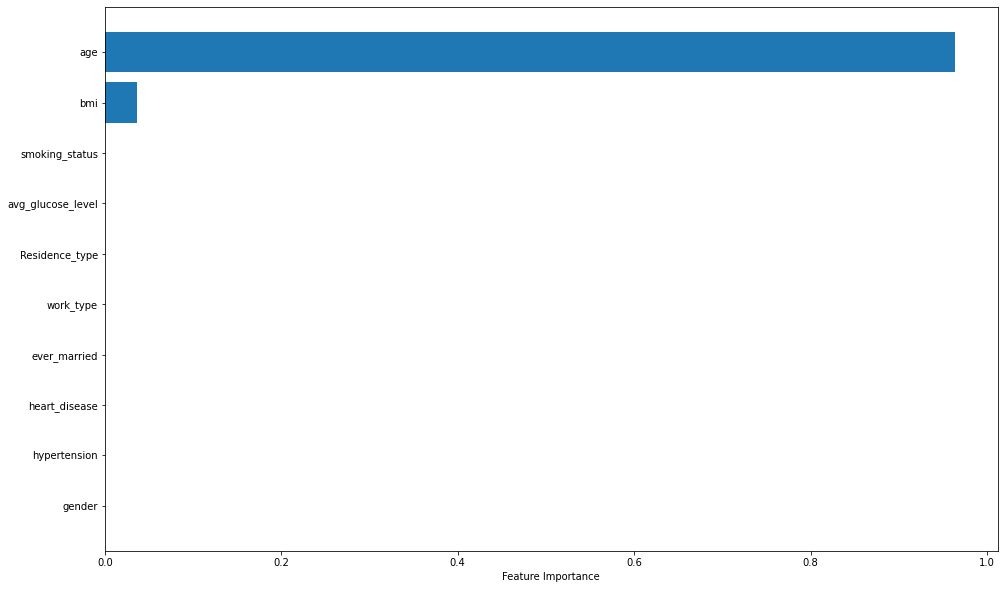

In [31]:
sort = model.best_estimator_.feature_importances_.argsort()
plt.rcParams["figure.figsize"] = (16, 10)
plt.barh( df.columns[sort], model.best_estimator_.feature_importances_[sort])
plt.xlabel("Feature Importance")

## MLPClassifier

In [32]:
clf = MLPClassifier(alpha=0.1, max_iter=500)
grid = {'alpha': [0.0001,],
        'hidden_layer_sizes':[(500,)],}
model = GridSearchCV(estimator = clf, param_grid = grid, cv = 5, verbose = 2, n_jobs = -1)
model.fit(X_train, y_train)
model.best_params_, model.score(X_train, y_train), model.score(X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


({'alpha': 0.0001, 'hidden_layer_sizes': (500,)},
 0.9542563600782779,
 0.9481409001956947)

## AdaBoost

In [33]:
clf = AdaBoostClassifier()
grid = {'n_estimators': [50,100, 500],
        'learning_rate':[0.1, 1, 10]}
model = GridSearchCV(estimator = clf, param_grid = grid, cv = 5, verbose = 2, n_jobs = -1)
model.fit(X_train, y_train)
model.best_params_, model.score(X_train, y_train), model.score(X_test, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({'learning_rate': 0.1, 'n_estimators': 50},
 0.951320939334638,
 0.9510763209393346)

Text(0.5, 0, 'Feature Importance')

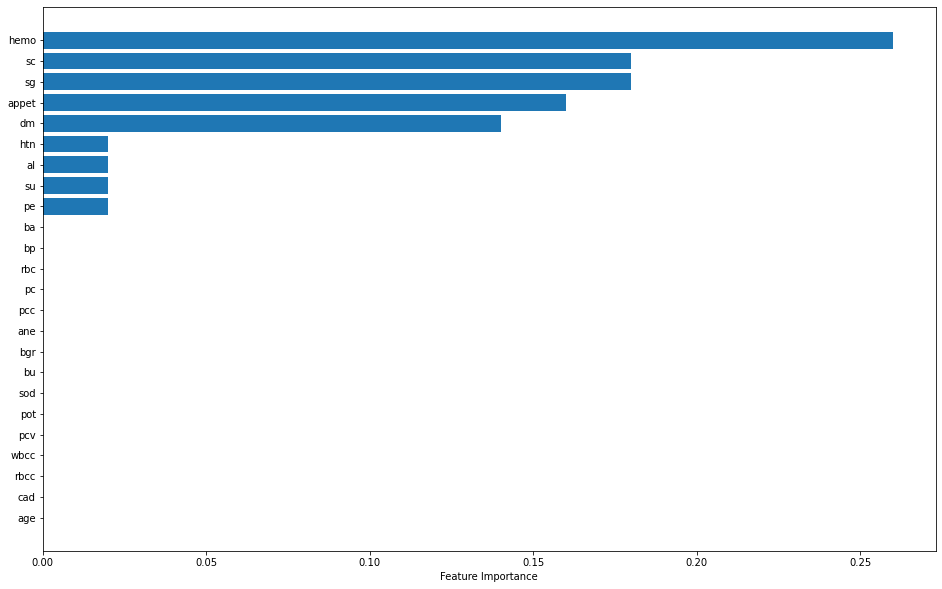

In [ ]:
sort = model.best_estimator_.feature_importances_.argsort()
plt.rcParams["figure.figsize"] = (16, 10)
plt.barh( df.columns[sort], model.best_estimator_.feature_importances_[sort])
plt.xlabel("Feature Importance")

## GAussianNB

In [54]:
clf = GaussianNB()
grid = {'var_smoothing': [1e-3, 1e-6, 1e-9, 1e-12]}
model = GridSearchCV(estimator = clf, param_grid = grid, cv = 5, verbose = 2, n_jobs = -1)
model.fit(X_train, y_train)
model.best_params_, model.score(X_train, y_train), model.score(X_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


({'var_smoothing': 0.001}, 0.8666829745596869, 0.8590998043052838)

## GradientBoostingClassifier

In [55]:
clf = GradientBoostingClassifier()
grid = {'max_depth': [2, 3, 5, 10, 15, 20],
        'n_estimators': [50, 100,],
        'learning_rate': [0.1, 1, 10]}
model = GridSearchCV(estimator = clf, param_grid = grid, cv = 5, verbose = 2, n_jobs = -1)
model.fit(X_train, y_train)
model.best_params_, model.score(X_train, y_train), model.score(X_test, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50},
 0.9518101761252447,
 0.9510763209393346)

Text(0.5, 0, 'Feature Importance')

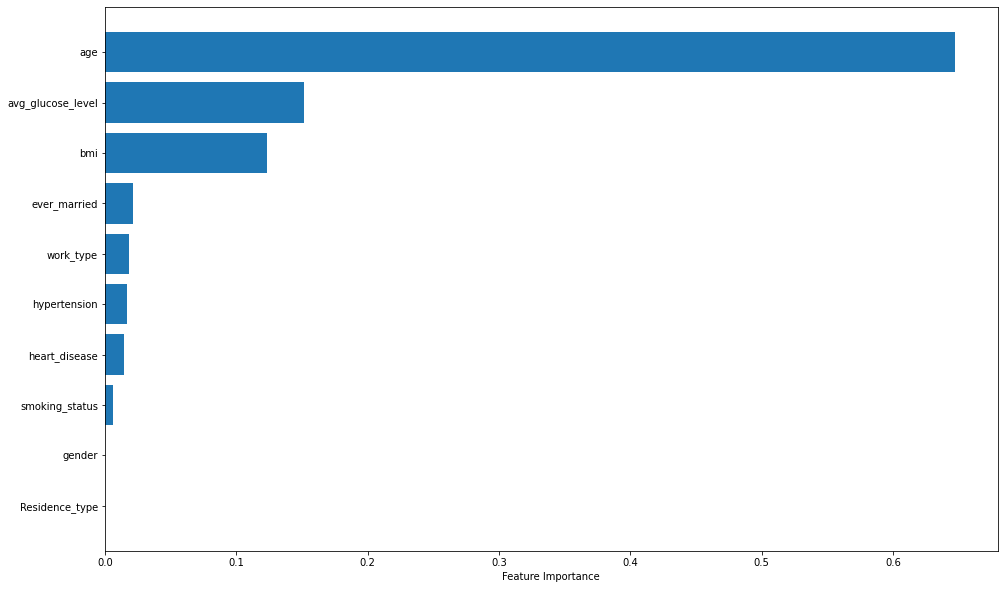

In [56]:
sort = model.best_estimator_.feature_importances_.argsort()
plt.rcParams["figure.figsize"] = (16, 10)
plt.barh( df.columns[sort], model.best_estimator_.feature_importances_[sort])
plt.xlabel("Feature Importance")

## XGBClassifier

In [57]:
clf = XGBClassifier()
grid = {'max_depth': [2, 3, 5, 10, 15, 20],
        'n_estimators': [50, 100,],
        'learning_rate': [0.1, 1, 10]}
model = GridSearchCV(estimator = clf, param_grid = grid, cv = 5, verbose = 2, n_jobs = -1)
model.fit(X_train, y_train)
model.best_params_, model.score(X_train, y_train), model.score(X_test, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50},
 0.951320939334638,
 0.9510763209393346)

Text(0.5, 0, 'Feature Importance')

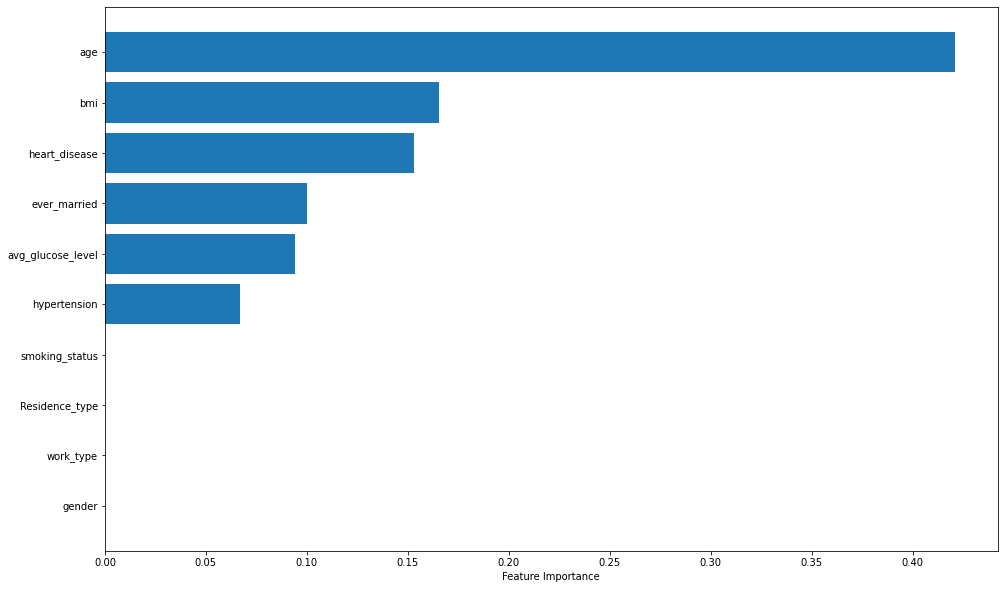

In [58]:
sort = model.best_estimator_.feature_importances_.argsort()
plt.rcParams["figure.figsize"] = (16, 10)
plt.barh( df.columns[sort], model.best_estimator_.feature_importances_[sort])
plt.xlabel("Feature Importance")

## PCA

In [79]:
pca = PCA(n_components=2)
X = pca.fit_transform(X)

fig = px.scatter(X, x=0, y=1, color=df['stroke'], color_discrete_sequence=px.colors.qualitative.Bold)
fig.show()

In [80]:
# Stratified Random split with test size 20%
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2)
split.get_n_splits(X, y)
train_idx, test_idx = next(split.split(X, y))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
X_train.shape, X_test.shape

((4088, 2), (1022, 2))

## Model Comparison

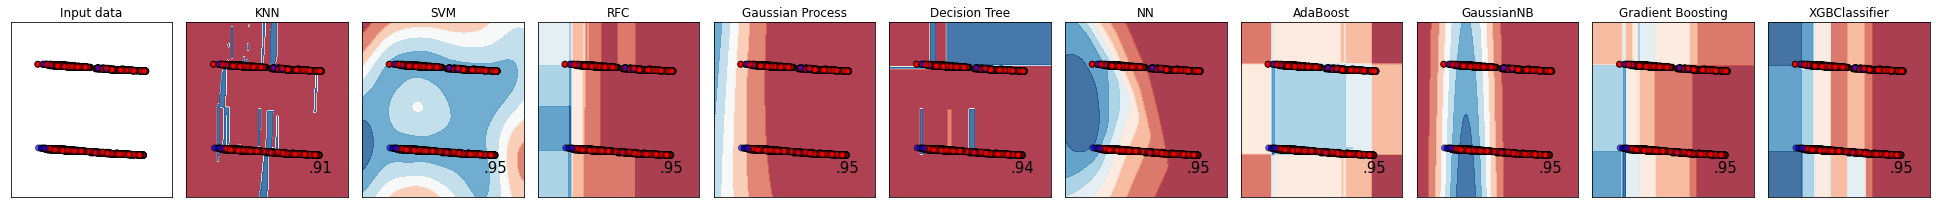

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = 0.02  # step size in the mesh

names = [
    "KNN",
    "SVM",
    "RFC",
    "Gaussian Process",
    "Decision Tree",
    "NN",
    "AdaBoost",
    "GaussianNB",
    "Gradient Boosting",
    "XGBClassifier"    
]

classifiers = [
    KNeighborsClassifier(leaf_size = 1, n_neighbors = 1),
    SVC(kernel="rbf", C=20, gamma = 'scale'),
    RandomForestClassifier(max_depth=3, max_features=2, ccp_alpha = 0),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=10, max_features='log2'),
    MLPClassifier(alpha=0.0001, hidden_layer_sizes = (500,)),
    AdaBoostClassifier(learning_rate=1, n_estimators=500),
    GaussianNB(),
    GradientBoostingClassifier(learning_rate=0.1, max_depth = 2, n_estimators = 50), 
    XGBClassifier(learning_rate=0.1, max_depth = 2, n_estimators = 50)
]


figure = plt.figure(figsize=(27, 3))
i = 1

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

    # iterate over classifiers
for name, clf in zip(names, classifiers):
    i += 1
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

    # Plot the training points
    ax.scatter(X[train_idx, 0], X[train_idx, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X[test_idx, 0],
        X[test_idx, 1],
        c=y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(
        xx.max() - 0.3,
        yy.min() + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )
    

plt.tight_layout()
plt.show()

In [ ]:
# tsne = TSNE(n_components = 2, verbose = 1, perplexity = 5, n_iter = 1000)
# X_ = tsne.fit_transform(X)

# fig = px.scatter(X_, x=0, y=1, color=df['stroke'], color_discrete_sequence=px.colors.qualitative.Bold)
# fig.show()